In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import ttest_ind
from scipy import stats
from scipy.stats import mannwhitneyu
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

In [ ]:
# Replace 'otu_file' with the path to your TSV file
otu_file = 'otu_table_psn_v35.txt'
# wget http://downloads.hmpdacc.org/data/HMQCP/otu_table_psn_v35.txt.gz
# Read the TSV file while skipping the first line
otu_data = pd.read_csv(otu_file, sep='\t', skiprows=1)
# otu_data = pd.read_csv("path_to_your_output_file.csv")
otu_data.columns.values[0] = 'otu_id'

# Define a function to parse the taxonomic data
def parse_tax_data(otu_data, class_cols, class_regex, class_key, class_sep):
    # Extract class information based on class_cols and class_sep
    tax_data = otu_data[class_cols].str.split(class_sep, expand=True)
    
    # Create a DataFrame for taxonomic classification
    tax_data.columns = [f'{class_key["hmp_rank"]}_{i}' for i in range(tax_data.shape[1])]
    tax_data[class_key["hmp_tax"]] = tax_data.apply(lambda row: class_sep.join(row.dropna()), axis=1)
    
    # Merge taxonomic data back with the original OTU data
    otu_data = otu_data.drop(columns=[class_cols])
    otu_data = pd.concat([otu_data, tax_data], axis=1)
    
    return otu_data

# # Apply the function to parse taxonomic data
hmp_data = parse_tax_data(otu_data, "Consensus Lineage", r"([a-z]{0,1})_{0,2}(.*)$", {"hmp_rank": "taxon_rank", "hmp_tax": "taxon_name"}, ";")

# # Remove the regex match table (not needed in this case)
otu_data = hmp_data.drop(columns=[col for col in hmp_data.columns if col.startswith('taxon_rank_')])

# # Rename the abundance matrix to something more understandable
otu_data.columns = ['otu_count' if col == 'otu_id' else col for col in otu_data.columns]
# Select the top 1000 rows
# top_1000_hmp_data = hmp_data.head(5)


# Extract the suffix of 'g__' in the 'taxon_name' column
otu_data['genus'] = otu_data['taxon_name'].str.extract(r'g__([^;]*)')
otu_data = otu_data[otu_data['genus'].notna() & (otu_data['genus'] != '')]
# # Delete the 'taxon_name' column
otu_data = otu_data.drop(columns=['taxon_name'])
# # Group by 'genus' and accumulate the OTU counts
# if 'genus' in otu_data.columns:
#     otu_data = otu_data.groupby('genus').sum().reset_index()
# else:
#     otu_data = otu_data  # If there is no 'genus' column, use the original data

# # Print the filtered DataFrame
# print(otu_data.head(5))
# otu_data = otu_data.drop(columns=['otu_count'])
num_rows, num_columns = otu_data.shape
# print(f'The DataFrame has {num_rows} rows and {num_columns} columns.')
# Rotate the DataFrame 90 degrees clockwise
otu_data = otu_data.transpose()

# Make the first row the header
otu_data.columns = otu_data.iloc[0]
otu_data = otu_data[1:]
otu_data.to_csv("genus_rotated.csv", index=False)
# Define the path for the output CSV file
# csv_file = 'path_to_your_output_file.csv'

# # Convert the DataFrame to a CSV file
# top_1000_hmp_data.to_csv(csv_file, index=False)


In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# Load the OTU table file
otu_table = pd.read_csv('genus_rotated_f.csv', header=0, index_col=None)
# Drop columns if all their values are 0
otu_table = otu_table.loc[:, (otu_table != 0).any(axis=0)]
# otu_table
# # Normalize the OTU counts (skip the first column if it's the sample IDs)
otu_table_proportions = otu_table.div(otu_table.sum(axis=1), axis=0)
print(otu_table_proportions)
# # Convert proportions to percentages
otu_table_percentages = otu_table_proportions*100
# print(genus_to_idx.head(5))
# # Save the normalized data to a CSV file
# otu_table_percentages.to_csv('otu_table_percentages.csv', index=False)
# # Create a dictionary to map genus names to unique indices
genus_names = otu_table_proportions.columns.tolist()
genus_to_idx = {genus: idx for idx, genus in enumerate(genus_names)}
class OTUDataset(Dataset):
    def __init__(self, data, genus_to_idx):
        self.data = data
        self.genus_to_idx = genus_to_idx
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        counts = self.data.iloc[idx].tolist()
        # print(counts)
        input_ids = [self.genus_to_idx[genus] for genus in self.genus_to_idx]
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'labels': torch.tensor(counts, dtype=torch.float)
        }

# Create a dataset and dataloader
dataset = OTUDataset(otu_table_proportions, genus_to_idx)
# print(dataset)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

     Abiotrophia  Acidaminococcus  Actinobacillus  Actinomyces  Adlercreutzia   
0            0.0         0.000000         0.00000     0.000000       0.000229  \
1            0.0         0.000000         0.00000     0.000000       0.000000   
2            0.0         0.006494         0.00000     0.000000       0.000000   
3            0.0         0.000000         0.00000     0.000000       0.000427   
4            0.0         0.000000         0.00028     0.000000       0.000000   
..           ...              ...             ...          ...            ...   
314          0.0         0.000000         0.00000     0.000000       0.000000   
315          0.0         0.000000         0.00000     0.000000       0.000000   
316          0.0         0.000000         0.00000     0.000257       0.000000   
317          0.0         0.000000         0.00000     0.000000       0.000000   
318          0.0         0.000000         0.00000     0.000554       0.000000   

     Aggregatibacter  Akker

Epoch 1/128, Loss: 0.2544
Epoch 2/128, Loss: 0.2290
Epoch 3/128, Loss: 0.2270
Epoch 4/128, Loss: 0.2243
Epoch 5/128, Loss: 0.2220
Epoch 6/128, Loss: 0.2221
Epoch 7/128, Loss: 0.2193
Epoch 8/128, Loss: 0.2182
Epoch 9/128, Loss: 0.2181
Epoch 10/128, Loss: 0.2171
Epoch 11/128, Loss: 0.2171
Epoch 12/128, Loss: 0.2162
Epoch 13/128, Loss: 0.2156
Epoch 14/128, Loss: 0.2150
Epoch 15/128, Loss: 0.2150
Epoch 16/128, Loss: 0.2151
Epoch 17/128, Loss: 0.2143
Epoch 18/128, Loss: 0.2130
Epoch 19/128, Loss: 0.2136
Epoch 20/128, Loss: 0.2138
Epoch 21/128, Loss: 0.2144
Epoch 22/128, Loss: 0.2144
Epoch 23/128, Loss: 0.2146
Epoch 24/128, Loss: 0.2134
Epoch 25/128, Loss: 0.2144
Epoch 26/128, Loss: 0.2133
Epoch 27/128, Loss: 0.2137
Epoch 28/128, Loss: 0.2133
Epoch 29/128, Loss: 0.2135
Epoch 30/128, Loss: 0.2121
Epoch 31/128, Loss: 0.2134
Epoch 32/128, Loss: 0.2129
Epoch 33/128, Loss: 0.2125
Epoch 34/128, Loss: 0.2136
Epoch 35/128, Loss: 0.2117
Epoch 36/128, Loss: 0.2129
Epoch 37/128, Loss: 0.2121
Epoch 38/1

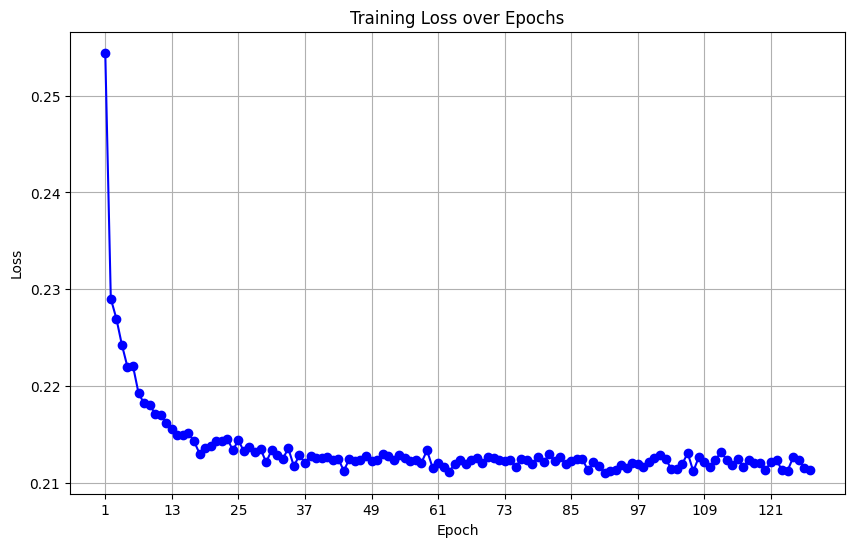

In [59]:
import time
import matplotlib.pyplot as plt
# Define the transformer model
class SimpleTransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward, max_seq_length):
        super(SimpleTransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = nn.Embedding(max_seq_length, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.regressor = nn.Linear(d_model, vocab_size)
        
    def forward(self, src, labels=None):
        src = self.embedding(src) + self.pos_encoder(torch.arange(src.size(1), device=src.device).unsqueeze(0).repeat(src.size(0), 1))
        output = self.transformer_encoder(src)
        output = output[:, 0, :]  # Use the first token representation for regression
        logits = self.regressor(output)
        
        loss = None
        if labels is not None:
            loss = nn.MSELoss()(logits, labels)
        
        return loss, logits
# Define the model parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = len(genus_to_idx)
d_model = 128
nhead = 4
num_encoder_layers = 4
dim_feedforward = 128
max_seq_length = len(genus_to_idx)
model = SimpleTransformerModel(vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward, max_seq_length).to(device)

# Training loop
optimizer = Adam(model.parameters(), lr=1e-3)
num_epochs = 128
start_time = time.time()
loss_values = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        loss, _ = model(input_ids, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    loss_values.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

end_time = time.time()
training_time = end_time - start_time
print(f'Training Time: {training_time:.2f} seconds')

# Save the model
torch.save(model.state_dict(), 'simple_transformer_model.pth')
# Plotting the loss function figure
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', color='b')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(range(1, num_epochs + 1, max(1, num_epochs // 10)))  # Adjust x-ticks for better readability
plt.show()

In [74]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import random
import time
# Load the OTU table file
otu_table = pd.read_csv('genus_rotated_f.csv', header=0, index_col=None)
# Drop columns if all their values are 0
otu_table = otu_table.loc[:, (otu_table != 0).any(axis=0)]
# Normalize the OTU counts (skip the first column if it's the sample IDs)
otu_table_proportions = otu_table.div(otu_table.sum(axis=1), axis=0)
otu_table_percentages = otu_table_proportions * 100
print(otu_table_percentages.shape)
# Create a dictionary to map genus names to unique indices
genus_names = otu_table_proportions.columns.tolist()
genus_to_idx = {genus: idx for idx, genus in enumerate(genus_names)}
idx_to_genus = {idx: genus for genus, idx in genus_to_idx.items()}
mask_token_idx = len(genus_to_idx)  # Assign the next index for the <MASK> token
genus_to_idx['<MASK>'] = mask_token_idx

class OTUDataset(Dataset):
    def __init__(self, data, genus_to_idx, mask_prob=0.1):
        self.data = data
        self.genus_to_idx = genus_to_idx
        self.mask_prob = mask_prob
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        counts = self.data.iloc[idx].tolist()
        input_ids = [self.genus_to_idx[genus] for genus in self.data.columns]
        
        # Apply masking
        masked_input_ids = input_ids.copy()
        for i in range(len(masked_input_ids)):
            if random.random() < self.mask_prob:
                masked_input_ids[i] = self.genus_to_idx['<MASK>']
        
        return {
            'input_ids': torch.tensor(masked_input_ids, dtype=torch.long),
            'labels': torch.tensor(counts, dtype=torch.float)
        }

# Create a dataset and dataloader
dataset = OTUDataset(otu_table_proportions, genus_to_idx, mask_prob=0.15)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

genus_to_idx


(319, 112)


{'Abiotrophia': 0,
 'Acidaminococcus': 1,
 'Actinobacillus': 2,
 'Actinomyces': 3,
 'Adlercreutzia': 4,
 'Aggregatibacter': 5,
 'Akkermansia': 6,
 'Alistipes': 7,
 'Allobaculum': 8,
 'Anaerococcus': 9,
 'Anaerofilum': 10,
 'Anaerofustis': 11,
 'Anaerostipes': 12,
 'Anaerotruncus': 13,
 'Anaerovorax': 14,
 'Asteroleplasma': 15,
 'Atopobium': 16,
 'Bacillus': 17,
 'Bacteroides': 18,
 'Bifidobacterium': 19,
 'Bilophila': 20,
 'Blautia': 21,
 'Brachymonas': 22,
 'Brachyspira': 23,
 'Bulleidia': 24,
 'Campylobacter': 25,
 'Capnocytophaga': 26,
 'Catenibacterium': 27,
 'Citrobacter': 28,
 'Cloacibacillus': 29,
 'Clostridium': 30,
 'Collinsella': 31,
 'Comamonas': 32,
 'Coprobacillus': 33,
 'Coprococcus': 34,
 'Corynebacterium': 35,
 'Dehalobacterium': 36,
 'Desulfovibrio': 37,
 'Dialister': 38,
 'Dorea': 39,
 'Dysgonomonas': 40,
 'Eggerthella': 41,
 'Enterococcus': 42,
 'Escherichia': 43,
 'Eubacterium': 44,
 'Faecalibacterium': 45,
 'Finegoldia': 46,
 'Fusobacterium': 47,
 'Gardnerella': 48

In [7]:
class SimpleTransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward, max_seq_length):
        super(SimpleTransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = nn.Embedding(max_seq_length, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.regressor = nn.Linear(d_model, len(genus_to_idx) - 1)  # Regress to original OTU dimensions
        
    def forward(self, src, labels=None):
        # Ensure the positional encoding matches the sequence length of src
        positions = torch.arange(0, src.size(1), device=src.device).unsqueeze(0).repeat(src.size(0), 1)
        src = self.embedding(src) + self.pos_encoder(positions)
        output = self.transformer_encoder(src)
        output = output[:, 0, :]  # Use the first token representation for regression
        logits = self.regressor(output)
        
        loss = None
        if labels is not None:
            loss = nn.MSELoss()(logits, labels)
        
        return loss, logits

# Define the model parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = len(genus_to_idx) + 1  # Add 1 for the <MASK> token
d_model = 256
nhead = 4
num_encoder_layers = 4
dim_feedforward = 512
max_seq_length = len(genus_to_idx)  # Number of unique genera
model = SimpleTransformerModel(vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward, max_seq_length).to(device)

# Training loop
optimizer = Adam(model.parameters(), lr=1e-7)
num_epochs = 128
start_time = time.time()
loss_values = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        loss, _ = model(input_ids, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    loss_values.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

end_time = time.time()
training_time = end_time - start_time
print(f'Training Time: {training_time:.2f} seconds')

# Save the model
torch.save(model.state_dict(), 'simple_transformer_model.pth')

# Plotting the loss function figure
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', color='b')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(range(1, num_epochs + 1, max(1, num_epochs // 10)))  # Adjust x-ticks for better readability
plt.show()

Epoch 1/128, Loss: 0.3079
Epoch 2/128, Loss: 0.3011
Epoch 3/128, Loss: 0.2904
Epoch 4/128, Loss: 0.2840
Epoch 5/128, Loss: 0.2757
Epoch 6/128, Loss: 0.2704
Epoch 7/128, Loss: 0.2630
Epoch 8/128, Loss: 0.2567
Epoch 9/128, Loss: 0.2496
Epoch 10/128, Loss: 0.2436
Epoch 11/128, Loss: 0.2378
Epoch 12/128, Loss: 0.2305
Epoch 13/128, Loss: 0.2242
Epoch 14/128, Loss: 0.2205
Epoch 15/128, Loss: 0.2147
Epoch 16/128, Loss: 0.2073
Epoch 17/128, Loss: 0.2033
Epoch 18/128, Loss: 0.1975
Epoch 19/128, Loss: 0.1936
Epoch 20/128, Loss: 0.1878
Epoch 21/128, Loss: 0.1852
Epoch 22/128, Loss: 0.1799
Epoch 23/128, Loss: 0.1747
Epoch 24/128, Loss: 0.1701
Epoch 25/128, Loss: 0.1658
Epoch 26/128, Loss: 0.1615
Epoch 27/128, Loss: 0.1579
Epoch 28/128, Loss: 0.1542
Epoch 29/128, Loss: 0.1498
Epoch 30/128, Loss: 0.1452
Epoch 31/128, Loss: 0.1435
Epoch 32/128, Loss: 0.1401
Epoch 33/128, Loss: 0.1347
Epoch 34/128, Loss: 0.1310
Epoch 35/128, Loss: 0.1284
Epoch 36/128, Loss: 0.1290
Epoch 37/128, Loss: 0.1216
Epoch 38/1

NameError: name 'plt' is not defined

In [3]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
0
NVIDIA GeForce RTX 3060


In [75]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

# Load the OTU table file
otu_table = pd.read_csv('genus_rotated_f.csv', header=0, index_col=None)
# Drop columns if all their values are 0
# otu_table = otu_table.loc[:, (otu_table != 0).any(axis=0)]
# Normalize the OTU counts (skip the first column if it's the sample IDs)
otu_table_proportions = otu_table.div(otu_table.sum(axis=1), axis=0)
# Convert proportions to percentages
otu_table_percentages = otu_table_proportions * 100
print(otu_table_percentages.shape)
# Create a dictionary to map genus names to unique indices
genus_names = otu_table_proportions.columns.tolist()
genus_to_idx = {genus: idx for idx, genus in enumerate(genus_names)}

class OTUDataset(Dataset):
    def __init__(self, data, genus_to_idx, mask_prob=0.30):
        self.data = data
        self.genus_to_idx = genus_to_idx
        self.mask_prob = mask_prob

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        counts = self.data.iloc[idx].tolist()
        input_ids = [self.genus_to_idx[genus] for genus in self.genus_to_idx]
        masked_ids, masked_labels = self.random_mask(counts)
        
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'labels': torch.tensor(counts, dtype=torch.float),
            'masked_labels': torch.tensor(masked_labels, dtype=torch.float)
        }
    
    def random_mask(self, counts):
        masked_labels = []
        for i in range(len(counts)):
            if np.random.rand() < self.mask_prob:
                masked_labels.append(counts[i])
                counts[i] = -1  # Masking this value
            else:
                masked_labels.append(-1)  # Not a target for prediction
        return counts, masked_labels

class SimpleTransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward, max_seq_length):
        super(SimpleTransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = nn.Embedding(max_seq_length, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.regressor = nn.Linear(d_model, vocab_size)
    
    def forward(self, src, masked_labels=None, compute_loss=True):
        # Ensure src is of type long
        src = src.long()  # Convert src to long if necessary

        # Positional encoding
        positions = torch.arange(src.size(1), device=src.device).unsqueeze(0).repeat(src.size(0), 1)
        src = self.embedding(src) + self.pos_encoder(positions)
        
        # Encoder
        output = self.transformer_encoder(src)
        output = output[:, 0, :]  # Use the first token representation for regression
        
        if compute_loss:
            # Regression
            logits = self.regressor(output) # vector
            
            # Loss calculation 
            loss = nn.MSELoss()(logits, masked_labels)
            #loss = nn.MSELoss()() 
            
            return loss, logits
        else:
            return output


(319, 393)


Epoch 1/128, Loss: 0.2704
Epoch 2/128, Loss: 0.2298
Epoch 3/128, Loss: 0.2284
Epoch 4/128, Loss: 0.2253
Epoch 5/128, Loss: 0.2238
Epoch 6/128, Loss: 0.2221
Epoch 7/128, Loss: 0.2214
Epoch 8/128, Loss: 0.2214
Epoch 9/128, Loss: 0.2194
Epoch 10/128, Loss: 0.2186
Epoch 11/128, Loss: 0.2179
Epoch 12/128, Loss: 0.2181
Epoch 13/128, Loss: 0.2169
Epoch 14/128, Loss: 0.2171
Epoch 15/128, Loss: 0.2157
Epoch 16/128, Loss: 0.2159
Epoch 17/128, Loss: 0.2169
Epoch 18/128, Loss: 0.2153
Epoch 19/128, Loss: 0.2150
Epoch 20/128, Loss: 0.2137
Epoch 21/128, Loss: 0.2144
Epoch 22/128, Loss: 0.2154
Epoch 23/128, Loss: 0.2141
Epoch 24/128, Loss: 0.2149
Epoch 25/128, Loss: 0.2145
Epoch 26/128, Loss: 0.2134
Epoch 27/128, Loss: 0.2144
Epoch 28/128, Loss: 0.2134
Epoch 29/128, Loss: 0.2144
Epoch 30/128, Loss: 0.2138
Epoch 31/128, Loss: 0.2142
Epoch 32/128, Loss: 0.2142
Epoch 33/128, Loss: 0.2139
Epoch 34/128, Loss: 0.2129
Epoch 35/128, Loss: 0.2134
Epoch 36/128, Loss: 0.2127
Epoch 37/128, Loss: 0.2138
Epoch 38/1

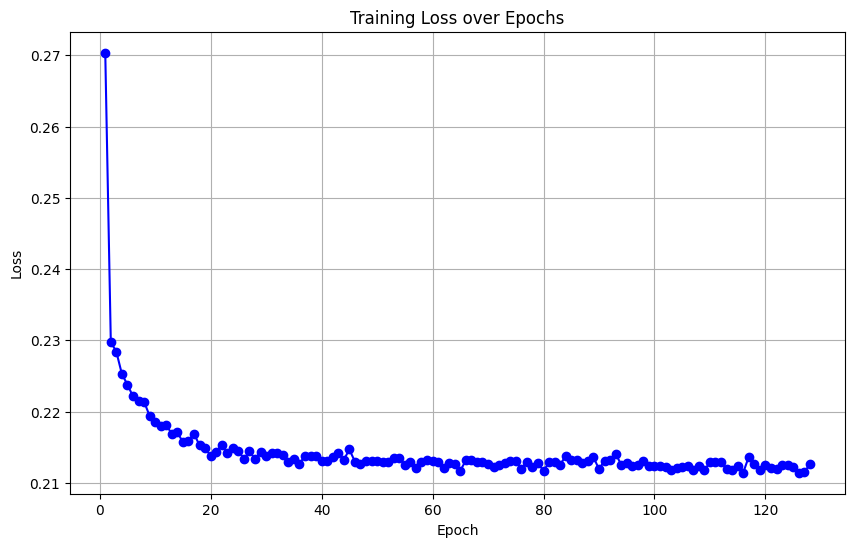

In [45]:
# Setup and training configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = len(genus_to_idx)
d_model = 128
nhead = 4
num_encoder_layers = 4
dim_feedforward = 128
max_seq_length = len(genus_to_idx)
model = SimpleTransformerModel(vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward, max_seq_length).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
num_epochs = 128

# Training loop with masked training
dataset = OTUDataset(otu_table_proportions, genus_to_idx)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
loss_values = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        masked_labels = batch['masked_labels'].to(device)
        
        optimizer.zero_grad()
        loss, _ = model(input_ids, masked_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    loss_values.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')
# Save the model
torch.save(model.state_dict(), 'transformer_base_model.pth')
# Plotting the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', color='b')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [30]:
import pandas as pd
# Read the data into a DataFrame
df = pd.read_csv("NSCLC.csv")
# Filter out columns that contain all zeros
# df = df.loc[:, (NSCLC != 0).any(axis=0)]
f1 = pd.read_csv('genus_rotated_f.csv')
# print(f1.shape)
# Extract genus-level data
df['Genus'] = df['#NAME'].apply(lambda x: x.split(';g__')[1].split(';')[0] if ';g__' in x else 'Unclassified')

# Select the relevant columns
genus_df = df[['Genus'] + df.columns[1:-1].tolist()]

# Filter out rows with "_unclassified" in the Genus column
NSCLC = genus_df[~genus_df['Genus'].str.contains('_unclassified')]
if 'Genus' in NSCLC.columns:
    NSCLC = NSCLC.groupby('Genus').sum().reset_index()
else:
    NSCLC = NSCLC  # If there is no 'genus' column, use the original data
NSCLC = NSCLC[NSCLC['Genus'].notna() & (NSCLC['Genus'] != '')]
NSCLC = NSCLC.loc[:, (NSCLC != 0).any(axis=0)]
NSCLC.set_index(NSCLC.columns[0], inplace=True)
f2 = NSCLC.transpose()
missing_cols = [col for col in f1.columns if col not in f2.columns]
# Add missing columns to f2 with values set to 0 using pd.concat
f2 = pd.concat([f2, pd.DataFrame(0, index=f2.index, columns=missing_cols)], axis=1)
# Drop columns from f2 that are not in f1
f2 = f2[f1.columns]
# Merge f2 to f1, keeping only the column names
f1 = f2
metadata  = pd.read_csv('metadata_response.csv')
metadata.set_index(metadata.columns[0], inplace=True)
# num_columns = len(merged_table.columns) - 1
merged_table = f1.join(metadata, how='inner')
# merged_table.to_csv("merged_table.csv",index=False)
# merged_table = merged_table.drop(columns=['Best response'])
response = merged_table['Best response']
otu_table_merge = merged_table.drop(columns=['Best response'])
# Drop the first column if it contains sample IDs or unnecessary data
otu_table_merge = otu_table_merge.iloc[:, 1:]

# Normalize OTU counts by total counts per sample
normalized_otu_counts = otu_table_merge.div(otu_table_merge.sum(axis=1), axis=0)

# Optionally, convert to percentages
normalized_otu_counts *= 100

# Print to verify
# normalized_otu_counts.to_csv("normalized_otu_counts.csv",index=False)
# Create a dictionary to map genus names to unique indices
genus_names = normalized_otu_counts.columns.tolist()
genus_to_idx = {genus: idx for idx, genus in enumerate(genus_names)}
genus_names
genus_to_idx
from sklearn.preprocessing import LabelEncoder

# Assuming 'merged_table' is your DataFrame containing the response and features
encoder = LabelEncoder()
merged_table['Best response'] = encoder.fit_transform(merged_table['Best response'])

# Separate features and target
# features = merged_table.drop('Best response', axis=1)
features = normalized_otu_counts
targets = merged_table['Best response']
targets

ERR2213660     1
ERR2213665     1
ERR2213666     1
ERR2213669     0
ERR2213672     0
              ..
SRR15373067    0
SRR15373089    0
SRR15373078    0
SRR15373012    0
SRR15373143    1
Name: Best response, Length: 417, dtype: int64

In [46]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
# MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x) # 100
        # [] [] crossentropyloss
        return x


In [47]:
class OTUDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        # Ensure data is returned as tensors
        x = torch.tensor(self.features.iloc[idx].values, dtype=torch.float32)
        y = torch.tensor(self.targets.iloc[idx], dtype=torch.long)  # Use torch.long for classification labels
        return x, y


In [48]:
from sklearn.model_selection import train_test_split
# Encode the 'Best response' column
encoder = LabelEncoder()
merged_table['Best response'] = encoder.fit_transform(merged_table['Best response'])

# Split the features and targets into training and testing sets
features_train, features_test, targets_train, targets_test = train_test_split(
    features, targets, test_size=0.2, random_state=42)
# print(features_test)
train_dataset = OTUDataset(features_train, targets_train)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataset = OTUDataset(features_test, targets_test)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)
# # Loop through the dataset
# for batch_idx, (x, y) in enumerate(train_dataloader):
#     print(f"Batch {batch_idx}:")
#     print("Features:", x)
#     print("Targets:", y)

In [49]:
# Define the model, loss function, and optimizer
num_classes = len(encoder.classes_)
# print(num_classes)
model = MLP(len(features.columns), 128, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, criterion, optimizer, dataloader, num_epochs=256):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}')

# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')


# Execute training and evaluation
train_model(model, criterion, optimizer, train_dataloader, num_epochs=128)
evaluate_model(model, test_dataloader)

Epoch [10/128], Loss: 0.4757
Epoch [20/128], Loss: 0.3195
Epoch [30/128], Loss: 0.2317
Epoch [40/128], Loss: 0.1277
Epoch [50/128], Loss: 0.0835
Epoch [60/128], Loss: 0.0606
Epoch [70/128], Loss: 0.0462
Epoch [80/128], Loss: 0.0384
Epoch [90/128], Loss: 0.0389
Epoch [100/128], Loss: 0.0332
Epoch [110/128], Loss: 0.0323
Epoch [120/128], Loss: 0.0281
Accuracy: 57.14%


In [50]:
def print_feature_importance(model, features):
    # Get the weights from the first linear layer
    weights = model.fc1.weight.data.abs().numpy()
    weight_importance = weights.sum(axis=0)  # Sum across rows to collapse into single importance per feature

    # Map weights to feature names
    feature_names = features.columns.tolist()
    feature_weights = pd.DataFrame({'Feature': feature_names, 'Weight': weight_importance})
    
    # Sort by importance
    sorted_features = feature_weights.sort_values(by='Weight', ascending=False)
    
    # Print the top features
    print(sorted_features.head(5))

# Execute the function
print_feature_importance(model, features)

            Feature     Weight
225  Microbacterium  60.807205
239       Neisseria  48.516289
317          Rothia  45.315216
69      Brachyspira  43.085003
376    Turicibacter  40.309814


In [70]:

vocab_size = len(genus_to_idx)
d_model = 128
nhead = 4
num_encoder_layers = 4
dim_feedforward = 128
max_seq_length = len(genus_to_idx)

transformer_model = SimpleTransformerModel(vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward, max_seq_length)
transformer_model.load_state_dict(torch.load('transformer_base_model.pth'))#simple_transformer_model transformer_base_model
transformer_model.eval()  # Set to eval mode to disable dropout, etc.


SimpleTransformerModel(
  (embedding): Embedding(393, 128)
  (pos_encoder): Embedding(393, 128)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (regressor): Linear(in_features=128, out_features=393, bias=True)
)

In [71]:
class EnhancedMLP(nn.Module):
    def __init__(self, pretrained_model, input_size, hidden_size, num_classes):
        super(EnhancedMLP, self).__init__()
        self.pretrained_model = pretrained_model
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.pretrained_model(x, compute_loss=False)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [72]:
# Train and evaluate the enhanced model
def train_and_evaluate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=256):
    # Check if GPU is available and move the model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    def train_model(model, criterion, optimizer, dataloader, num_epochs):
        model.train()
        for epoch in range(num_epochs):
            total_loss = 0
            for inputs, labels in dataloader:
                # Move inputs and labels to GPU
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}')

    def evaluate_model(model, dataloader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in dataloader:
                # Move inputs and labels to GPU
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f'Accuracy: {accuracy:.2f}%')

    # Train the model
    train_model(model, criterion, optimizer, train_dataloader, num_epochs)
    
    # Evaluate the model
    evaluate_model(model, test_dataloader)

hidden_size = 128
enhanced_model = EnhancedMLP(transformer_model, d_model, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(enhanced_model.parameters(), lr=0.001)

# Train and evaluate the enhanced model
train_and_evaluate(enhanced_model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=128)

Epoch [10/128], Loss: 0.6922
Epoch [20/128], Loss: 0.6921
Epoch [30/128], Loss: 0.6927
Epoch [40/128], Loss: 0.6918
Epoch [50/128], Loss: 0.6913
Epoch [60/128], Loss: 0.6912
Epoch [70/128], Loss: 0.6913
Epoch [80/128], Loss: 0.6913
Epoch [90/128], Loss: 0.6913
Epoch [100/128], Loss: 0.6922
Epoch [110/128], Loss: 0.6921
Epoch [120/128], Loss: 0.6912
Accuracy: 52.38%
